# Asennusmäärän ennustaminen vertaamalla vuoden takaiseen

Pohjautuu edelliseen versioon. Siksi kommentointia on vähemmän alussa.

Tässä versiossa asennusmäärän ennustamisessa malleille annettua opetusaineistoa on supistettu siten, että sen aikasarjat osuvat täsmälleen samoihin kuukausiin kuin ennustettava ajanjakso. Myös tässä versiossa ennustettavia arvoja ei päädy opetusaineistoon.

## Kirjastot

Mukana itse koodattu esikäsittelijä.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from datetime import datetime

import importlib.util
import sys
file_path = "../../Tehtava-03/preprocessor.py"; module_name = "preprocessor"; spec = importlib.util.spec_from_file_location(module_name, file_path)
esik = importlib.util.module_from_spec(spec); sys.modules[module_name] = esik; spec.loader.exec_module(esik)


## Esikäsittelijän ajaminen

In [2]:
customer_segment = 'customer_segment'
cols = ['installation_date', customer_segment]
df_all = esik.esik(cols)


## Esikäsittely jatkuu

### Luodaan aikasarja

Aikasarjan indeksinä on oletuksena kuukausi ja arvona kaikkien kyseisen kuukauden aikana tehtyjen asennusten määrä valitussa asiakassegmentissä. Merkitään myös nollat.

In [3]:
df = df_all.copy()
# Valitaan tarkasteltava asiakasryhmä
df = df[df[customer_segment] == 'RES']
df.drop([customer_segment], axis=1, inplace=True)

# Aika-askel
freq = 'M'  # Voi olla myös 'W'
time_format = '%Y-%m'  # Vaihdetaan '%Y-%W', jos käsitellään viikottaista asennusmäärää

# Lasketaan asennukset
df['time_step'] = df['installation_date'].dt.strftime(time_format)
df = df['time_step'].value_counts().sort_index()
df = pd.DataFrame({'time_step': df.index, 'count': df})

# Tavoiteltava indeksi
index_period = pd.period_range(start='1998-01-01', end='2019-12-29', freq=freq).strftime(time_format)
period = pd.DataFrame(data=index_period, columns=['time_step'], dtype='object')
index_period = pd.period_range(start='1998-01-01', end='2019-12-29', freq=freq)

# Yhdistetään ja lisätään nollat
df_time_serie = period.merge(df, how='left', on='time_step')
df_time_serie.fillna(0, inplace=True)
df_time_serie.index = index_period
df_time_serie.drop(['time_step'], axis=1, inplace=True)
display(df_time_serie)


,count
1998-01,1.0
1998-02,1.0
1998-03,0.0
1998-04,1.0
1998-05,2.0
...,...
2019-08,13571.0
2019-09,13073.0
2019-10,13019.0
2019-11,13405.0


### Muokataan ja valitaan data mallia varten

Tässä vaiheessa valitaan data määrittämällä aikaväli. Valinta määrää käytännössä opetusaineiston alkupisteen ja ennusteen loppupisteen. Samalla valitaan mallin käyttämän syötteen ja tehtävän ennusteen pituus, joka määritetään aika-askelina.

Käytetään liukuvaa keskiarvoa, koska se pyöristää vaihteluita jonkin verran. Sarakkeen nimeksi vaihdetaan `x_0`, mikä selkeyttää datan käyttöä mallissa.

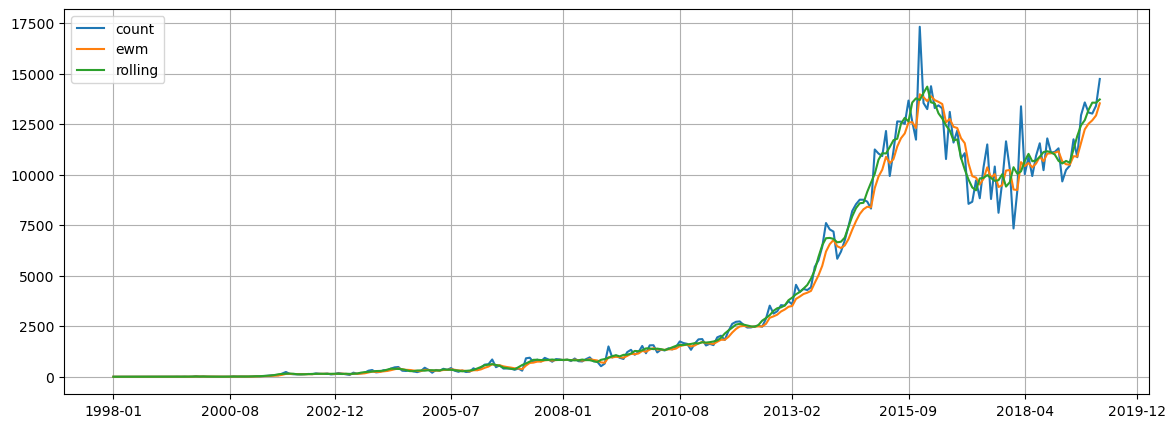

df_ML.shape: (264, 1)


,x_0
2019-09,13200.800000
2019-10,13559.800000
2019-11,13557.000000
2019-12,13718.333333


In [82]:
start = '1998-01-01'
end = '2019-12-29'

input_len = 6
output_len = 6

# Vertailuarvot
df = df_time_serie.copy()
df['ewm_count'] = df['count'].ewm(com=2).mean()
df['rolling_count'] = df['count'].rolling(5, min_periods=3, center=True).mean()

# Rajaus
a = datetime.fromisoformat(start).strftime(time_format)
b = datetime.fromisoformat(end).strftime(time_format)
df = df.loc[a:b,:]

# Piirto

# Varaudutaan käyttämään myös alueen ylittävää päiväystä kuvassa
x_ticks_range = pd.period_range(start=start, end='2023-12-01', freq=freq).strftime(time_format)
N = len(df)
def format_date(x, pos=None):
  thisind = np.clip(int(x + 0.5), 0, N - 1)
  return x_ticks_range[thisind]

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(np.arange(N), df['count'], label='count')
ax.plot(np.arange(N), df['ewm_count'], label='ewm')
ax.plot(np.arange(N), df['rolling_count'],  label='rolling')
if N > 24:
  locator = mdates.AutoDateLocator(minticks=6, maxticks=16)
  ax.xaxis.set_major_locator(locator)
  ax.xaxis.set_major_formatter(format_date)
else:
  fig.autofmt_xdate()
ax.legend()
ax.grid()
plt.show()

#df['x_0'] = df['count']
#df['x_0'] = df['ewm_count']
df['x_0'] = df['rolling_count']
df.drop(['count', 'ewm_count', 'rolling_count'], axis=1, inplace=True)
df_ML = df.copy()
print("df_ML.shape:", df_ML.shape)
display(df_ML.tail(4))


## Malli

Muokataan dataa siten, että jokaiselle riville muodostuu syöte ja sen perusteella ennustettavat arvot. Tällöin rivin indeksi ilmaisee vain syötteen ensimmäisen pisteen ajankohdan. Se toisaalta määrää myös muiden syötteen sekä ennusteen pisteiden paikat, joten niille ei tarvitse tehdä mitään.

### Funktio, jolla muodostetaan mallille annettava syöte ja odotettu tulos (input ja output)

In [16]:
# Source: https://towardsdatascience.com/the-complete-guide-to-time-series-forecasting-using-sklearn-pandas-and-numpy-7694c90e45c1
def window_input_output(input_length: int, output_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df = data.copy()
    
    i = 1
    while i < input_length:
        df[f'x_{i}'] = df['x_0'].shift(-i)
        i = i + 1
        
    j = 0
    while j < output_length:
        df[f'y_{j}'] = df['x_0'].shift(-input_length-j)
        j = j + 1
        
    df = df.dropna(axis=0)
    
    return df


In [83]:
seq_df = window_input_output(input_len, output_len, df_ML)
print("seq_df.shape:", seq_df.shape)
seq_df.tail(4)


seq_df.shape: (253, 12)


,x_0,x_1,x_2,x_3,x_4,x_5,y_0,y_1,y_2,y_3,y_4,y_5
2018-10,11155.2,11105.2,10993.6,10681.2,10552.2,10677.2,10589.2,11243.8,11912.0,12438.0,12692.0,13200.800000
2018-11,11105.2,10993.6,10681.2,10552.2,10677.2,10589.2,11243.8,11912.0,12438.0,12692.0,13200.8,13559.800000
2018-12,10993.6,10681.2,10552.2,10677.2,10589.2,11243.8,11912.0,12438.0,12692.0,13200.8,13559.8,13557.000000
2019-01,10681.2,10552.2,10677.2,10589.2,11243.8,11912.0,12438.0,12692.0,13200.8,13559.8,13557.0,13718.333333


### Train test split

Viimeinen `seq_df`:n rivi on jälleen testirivi. Opetusdatan valitseminen aloitetaan poistamalla lopusta rivejä jättäen viimeiseksi riviksi opetusdatan viimeisen rivin, jossa syöte alkaa samasta kuukaudesta kuin testirivin syöte.

In [84]:
test_size = 1
tail_cut = int((output_len - 1) / 12 + 1) * (-12)

seq_df_train = seq_df[:tail_cut:]
seq_df_train.tail(4)


,x_0,x_1,x_2,x_3,x_4,x_5,y_0,y_1,y_2,y_3,y_4,y_5
2017-10,10020.6,9408.0,9622.2,10366.2,10042.0,10161.2,10679.4,11027.2,10661.6,10700.6,10882.8,11114.8
2017-11,9408.0,9622.2,10366.2,10042.0,10161.2,10679.4,11027.2,10661.6,10700.6,10882.8,11114.8,11155.2
2017-12,9622.2,10366.2,10042.0,10161.2,10679.4,11027.2,10661.6,10700.6,10882.8,11114.8,11155.2,11105.2
2018-01,10366.2,10042.0,10161.2,10679.4,11027.2,10661.6,10700.6,10882.8,11114.8,11155.2,11105.2,10993.6


Seuraavaksi opetusdataksi valitaan lopusta alkaen joka 12. rivi. Lopuksi rivit palautetaan alkamaan vanhimmasta uusimpaan kääntämällä järjestys.

In [85]:
seq_df_train = seq_df_train[::-12]
seq_df_train = seq_df_train[::-1]
seq_df_train.tail(4)

,x_0,x_1,x_2,x_3,x_4,x_5,y_0,y_1,y_2,y_3,y_4,y_5
2015-01,10736.4,11059.0,11045.4,11363.6,11703.8,11774.6,12520.6,12809.6,12629.0,13567.6,13773.8,13689.4
2016-01,14039.8,14352.6,13575.6,13522.6,13028.6,12774.6,12432.8,12183.2,11687.0,11745.2,10835.4,10250.0
2017-01,9756.6,9363.8,9223.6,9811.4,9838.4,9975.8,9831.8,9691.4,9722.2,10020.6,9408.0,9622.2
2018-01,10366.2,10042.0,10161.2,10679.4,11027.2,10661.6,10700.6,10882.8,11114.8,11155.2,11105.2,10993.6


Seuraavaksi tehdään jako `x`- ja `y`-sarakkeisiin.

In [86]:
X_cols = [col for col in seq_df.columns if col.startswith('x_')]
y_cols = [col for col in seq_df.columns if col.startswith('y_')]

X_train = seq_df_train[X_cols][:].values
y_train = seq_df_train[y_cols][:].values

X_test = seq_df[X_cols][-test_size:].values
y_test = seq_df[y_cols][-test_size:].values


### Mallien koulutus ja ennuste

Käytetään kolmea malllia.

In [87]:
dt_seq = DecisionTreeRegressor(random_state=9)
dt_seq.fit(X_train, y_train)
dt_seq_preds = dt_seq.predict(X_test)

rf_seq = RandomForestRegressor(random_state=9)
rf_seq.fit(X_train, y_train)
rf_seq_preds = rf_seq.predict(X_test)

lr_seq = LinearRegression()
lr_seq.fit(X_train, y_train)
lr_seq_preds = lr_seq.predict(X_test)


## Tulosten piirto

Piirretään kuvaajaan saadut tulokset. Syöte on molemmille malleille sama.

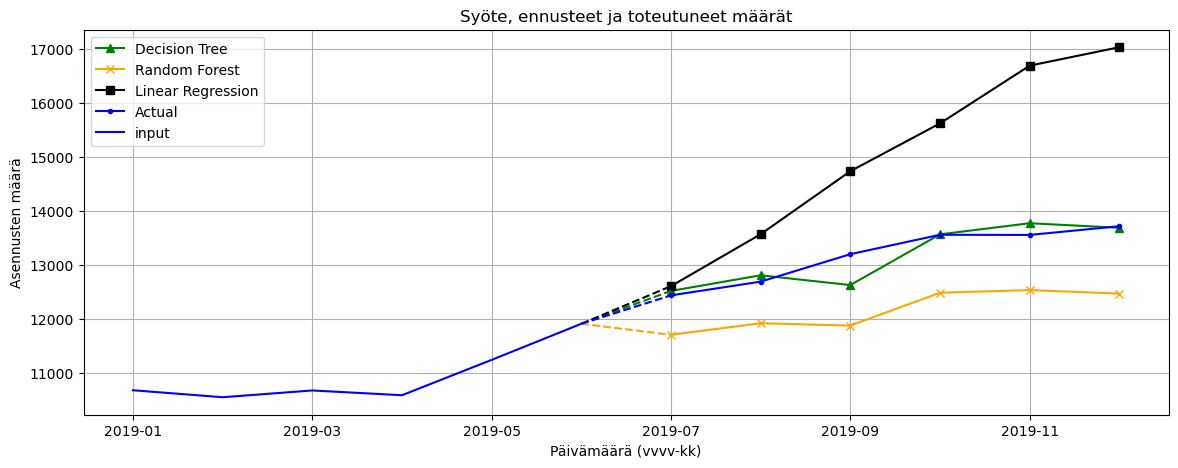

,Actual,Decision Tree,Random Forest,Linear Regression
2019-07,12438.000000,12520.6,11708.128,12608.840530
2019-08,12692.000000,12809.6,11921.664,13570.289653
2019-09,13200.800000,12629.0,11878.632,14736.713506
2019-10,13559.800000,13567.6,12486.362,15622.321940
2019-11,13557.000000,13773.8,12535.912,16691.024235
2019-12,13718.333333,13689.4,12470.658,17032.494925


In [91]:
a = input_len
b = input_len + output_len
N = len(seq_df)

def format_date_2(x1, pos=None):
  thisind = np.clip(int(x1 + 0.5), 0, N - 1)
  return x_ticks_range[N - test_size + thisind]

# Piirto
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(np.arange(a, b, 1), dt_seq_preds[0], marker='^', color='green', label='Decision Tree')
ax.plot(np.arange(a, b, 1), rf_seq_preds[0], marker='x', color='orange', label='Random Forest')
ax.plot(np.arange(a, b, 1), lr_seq_preds[0], marker='s', color='black', label='Linear Regression')
ax.plot(np.arange(a, b, 1), y_test[0], marker='.', color='blue', label='Actual')

ax.plot(np.arange(0, a, 1), X_test[0], 'b-', label='input')

ax.plot(np.arange(a - 1, a + 1, 1), np.array([X_test[0][a - 1], dt_seq_preds[0][0]]), linestyle='--', color='green')
ax.plot(np.arange(a - 1, a + 1, 1), np.array([X_test[0][a - 1], rf_seq_preds[0][0]]), linestyle='--', color='orange')
ax.plot(np.arange(a - 1, a + 1, 1), np.array([X_test[0][a - 1], lr_seq_preds[0][0]]), linestyle='--', color='black')
ax.plot(np.arange(a - 1, a + 1, 1), np.array([X_test[0][a - 1], y_test[0][0]]), linestyle='--', color='blue')

if b > 20:
  locator = mdates.AutoDateLocator(minticks=8, maxticks=12)
else:
  locator = mdates.AutoDateLocator(minticks=3, maxticks=12)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(format_date_2)
#fig.autofmt_xdate()
ax.set_xlabel('Päivämäärä (vvvv-kk)')
ax.set_ylabel('Asennusten määrä')
ax.set_title('Syöte, ennusteet ja toteutuneet määrät')
ax.legend()
ax.grid()
plt.show()

res = pd.DataFrame({
  'Actual': y_test[0],
  'Decision Tree': dt_seq_preds[0],
  'Random Forest': rf_seq_preds[0],
  'Linear Regression': lr_seq_preds[0]},
  index=df_ML.index[-output_len:])
display(res)

### Vertailukohde

Saadun tuloksen virhe on keskimäärin suurempi kuin aikaisemmalla mallilla. Vertailukuva alla.

![pred1](images/aikasaraja_pred1.png)

Tarkistuksessa selvisi, että `Decision Tree` antoi täsmälleen saman ennusteen, `Random Forest` vähän heikomman (virhe 1,1 %-yksikköä suurempi) ja `Linear Regression` ajautui hyvin kauas edellisestä ennusteesta tehden kaikista eniten virhettä.


## Virheen laskenta

Arvioidaan mallien toimivuuttaa tässä testissä laskemalla ennusteen keskimääräinen virhe (mean absolute percentage error, MAPE).

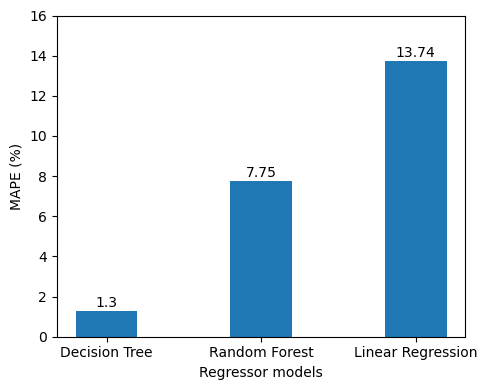

In [92]:
def mape(y_true, y_pred):
  return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

dt_mape = mape(y_test[0], dt_seq_preds[0])
rf_mape = mape(y_test[0], rf_seq_preds[0])
lr_mape = mape(y_test[0], lr_seq_preds[0])

# Generate bar plot
fig, ax = plt.subplots(figsize=(5, 4))
x = ['Decision Tree', 'Random Forest', 'Linear Regression']
y = [dt_mape, rf_mape, lr_mape]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, int(np.array(y).max() * 1.1 + 1))

for index, value in enumerate(y):
  plt.text(x=index, y=value + 0.2, s=str(value), ha='center')
    
plt.tight_layout()

## Arvio mallin toimivuudesta

Tekemällä useita eri pituisia ennustuksia eri aikaväleillä voi huomata, että tulokset vaihtelevat paljon. Toisinaan virhe voi kasvaa todella suureksi, etenkin ennusteen pituuden kasvaessa. Siten mallin ennusteet eivät herätä juuri lainkaan luottamusta. Parhaimpien tulosten taustalla lienee enemmän tuuria kuin taitoa tai tietoa.

Tulosten heittelehtiminen tosin tuskin johtuu yksin algoritmeista tai datan käsittelystä. Todennäköisempää on, että ennustamisen vaikeuden takana on itse asian eli asennusmäärän ennustamisen vaikeus, joka on pääteltävissä käytettävissä olevasta datasta. Toisaalta mallit toimivat jonkin verran paremmin, jos ennustuksen ja opetusaineiston aikaväli valitaan tarkemmin ennustettavammista kohdista, esimerkiksi lineaarisen kasvun kohdalta. Silloin toisaalta saatetaan pedata liian helppo paikka mallille tehdä ennuste, jolloin ikään kuin tehdään oletus siitä, että tilanne ja olosuhteet voisivat jatkua samankaltaisina. Todellisuudessa vastaavan oletuksen tekeminen on mahdollisesti joiltain osin virheellinen.

Tulokset eivät myöskään parantuneet tässä mallissa käytetyllä menetelmällä valita opetusaineisto vain samaan aikaan vuodesta olevista aikasarjoista. Tulos ei ole kovin yllättävä, sillä asennusmäärien kehityksessä ei ollut nopean arvion perusteella havaittavissa merkittävää vuodenajasta riippuvaa kausivaihtelua, jonka havaitsemiseen tämä malli olisi arviolta ollut sopivampi.

### Jatkokehitys

Vaikuttaa siltä, että mallissa olisi vielä paljon kehitettävää parempien ja tietyin varauksin luotettavampien tulosten saavuttamiseksi. Seuraavat kehitysaskeleet voisivat pyrkiä huomioimaan muun muassa kuukauden aikana asennuksiin annetun tuen määrän, vaikka siinä vaiheessa kyseessä ei enää olisikaan pelkkä aikasarjaennuste. Siten voisikin olla hyvä kokeilla täysin erilaisia tapoja yrittää tehdä ennuste. Nyt käytetty aikasarjaennustus sopisi arviolta paremmin hyvin säännöllisille data-aineistoille, jollaisesta tässä datassa ei ollut kyse.